# Fine-Tuned BioBERT for Symptom-Based Disease Diagnosis and Medication Recommendation

**MSc Dissertation Notebook**  
**Focus**: Fine-tuning BioBERT (dmis-lab/biobert-v1.1) for disease classification from symptom text prompts  
**Dataset**: Merged Disease Symptom Prediction dataset (41 diseases)  
**Novelty**: Severity-aware medication selection + ROUGE evaluation of recommendations  

Run cells in order. Each section shows output immediately.

## 1: Install Required Packages

In [1]:
!pip install -q transformers datasets torch scikit-learn pandas numpy rouge-score accelerate torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

print("All packages installed successfully!")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.2 MB/s eta 0:00:00
All packages installed successfully!


## 2: Import Libraries & Setup Device

In [2]:
import pandas as pd
import numpy as np
import torch
import warnings
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from rouge_score import rouge_scorer
from google.colab import files
import os
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
from scipy.sparse import coo_matrix

warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device setup complete")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_sparse/_version_cuda.so
  import torch_geometric.typing


Device setup complete
Using device: cuda
GPU name: Tesla T4


## 3: Load the Dataset

In [5]:
print("Loading dataset...")
if not os.path.exists('/content/merged_dataset.csv'):
    print("Upload merged_dataset.csv")
    uploaded = files.upload()

df_raw = pd.read_csv('/content/merged_dataset.csv')
print(f"Raw dataset loaded: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns")

display(df_raw.head(5))

Loading dataset...
Raw dataset loaded: 36480 rows, 147 columns


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,Symptom_4,Description,Medication,Precaution,Workout,Age,Gender,Allergies,prognosis_encoded,Demographics
0,1,1,1,0,0,0,0,0,0,0,...,dischromic_patches,Fungal infection is a common skin condition ca...,"['Antifungal Cream', 'Fluconazole', 'Terbinafi...","['bath twice', 'use detol or neem in bathing w...","['Avoid sugary foods', 'Consume probiotics', '...",57,male,NaN,15,"57, male, nan"
1,1,1,1,0,0,0,0,0,0,0,...,NaN,Fungal infection is a common skin condition ca...,"['Antifungal Cream', 'Fluconazole', 'Terbinafi...","['bath twice', 'use detol or neem in bathing w...","['Avoid sugary foods', 'Consume probiotics', '...",47,female,penicillin,15,"47, female, penicillin"
2,1,1,1,0,0,0,0,0,0,0,...,NaN,Fungal infection is a common skin condition ca...,"['Antifungal Cream', 'Fluconazole', 'Terbinafi...","['bath twice', 'use detol or neem in bathing w...","['Avoid sugary foods', 'Consume probiotics', '...",59,male,penicillin,15,"59, male, penicillin"
3,1,1,1,0,0,0,0,0,0,0,...,NaN,Fungal infection is a common skin condition ca...,"['Antifungal Cream', 'Fluconazole', 'Terbinafi...","['bath twice', 'use detol or neem in bathing w...","['Avoid sugary foods', 'Consume probiotics', '...",72,male,NaN,15,"72, male, nan"
4,1,1,1,0,0,0,0,0,0,0,...,NaN,Fungal infection is a common skin condition ca...,"['Antifungal Cream', 'Fluconazole', 'Terbinafi...","['bath twice', 'use detol or neem in bathing w...","['Avoid sugary foods', 'Consume probiotics', '...",46,male,aspirin,15,"46, male, aspirin"


## 4: Clean the Dataset

In [6]:
print("\nCleaning dataset...")
initial_rows = len(df_raw)
df = df_raw.dropna().drop_duplicates().reset_index(drop=True)
print(f"After removing NaN and duplicates: {len(df)} rows ({initial_rows - len(df)} removed)")


Cleaning dataset...
After removing NaN and duplicates: 12267 rows (24213 removed)


## 5: Parse Medications & Create Disease-to-Meds Mapping

### 5.1. Load the severity medications dataset

In [7]:
severity_df = pd.read_csv('/content/severity_med_priority.csv')
print("\nFile loaded successfully!")

print(f"Raw dataset loaded: {severity_df.shape[0]} rows, {severity_df.shape[1]} columns")

print("\nLoading First 10 rows of dataset:")
display(severity_df.head(10))


File loaded successfully!
Raw dataset loaded: 123 rows, 4 columns

Loading First 10 rows of dataset:


,disease,severity,medication1,medication2
0,Fungal infection,Mild,Antifungal Cream,Clotrimazole
1,Fungal infection,Moderate,Fluconazole,Ketoconazole
2,Fungal infection,Severe,Terbinafine,NaN
3,Allergy,Mild,Antihistamines,Topical corticosteroids
4,Allergy,Moderate,Antihistamines,Oral corticosteroids
5,Allergy,Severe,Epinephrine,IV corticosteroids
6,Diabetes,Mild,Metformin,Lifestyle changes
7,Diabetes,Moderate,Metformin,Sulfonylureas
8,Diabetes,Severe,Insulin,Metformin
9,Gastroenteritis,Mild,Oral rehydration,Antiemetics


### 5.2: Parse Medications & Create Disease-to-Meds Mapping


In [8]:
def parse_meds(cell):
    try: return [m.strip() for m in eval(cell)] if isinstance(eval(cell), (list,tuple)) else []
    except: return []
df['meds_list'] = df['Medication'].apply(parse_meds)

disease_to_meds = df.groupby('prognosis')['meds_list'].agg(lambda x: list({m for sub in x for m in sub})).to_dict()

severity_priority = {}
for _, row in severity_df.iterrows():
    disease = row['disease']
    severity = row['severity']
    meds = [row['medication1'], row['medication2']]
    meds = [m for m in meds if pd.notna(m) and m.strip() != '']  # Remove NaN/empty
    if disease not in severity_priority:
        severity_priority[disease] = {}
    severity_priority[disease][severity] = meds

print(f"Severity mapping loaded for {len(severity_priority)} diseases")
print("Sample (first 3 diseases):")
for disease in list(severity_priority.keys())[:3]:
    print(f"  {disease}: {severity_priority[disease]}")

Severity mapping loaded for 41 diseases
Sample (first 3 diseases):
  Fungal infection: {'Mild': ['Antifungal Cream', 'Clotrimazole'], 'Moderate': ['Fluconazole', 'Ketoconazole'], 'Severe': ['Terbinafine']}
  Allergy: {'Mild': ['Antihistamines', 'Topical corticosteroids'], 'Moderate': ['Antihistamines', 'Oral corticosteroids'], 'Severe': ['Epinephrine', 'IV corticosteroids']}
  Diabetes : {'Mild': ['Metformin', 'Lifestyle changes'], 'Moderate': ['Metformin', 'Sulfonylureas'], 'Severe': ['Insulin', 'Metformin']}


## 6: Identify Symptom Columns & Create Text Prompts

In [9]:
metadata_cols = ['prognosis','Disease','Symptom_1','Symptom_2','Symptom_3','Symptom_4',
                 'Description','Medication','Precaution','Workout','Age','Gender',
                 'Allergies','prognosis_encoded','Demographics','meds_list']
symptom_cols = [c for c in df.columns if c not in metadata_cols]

print(f"Detected {len(symptom_cols)} binary symptom columns")

def create_prompt(row):
    active_syms = [c.replace('_', ' ') for c in symptom_cols if row[c] == 1]
    sym_text = ', '.join(active_syms) if active_syms else "no symptoms reported"
    age = int(row['Age'])
    gender = row['Gender'].lower()
    return f"Symptoms: {sym_text}. Age: {age}. Gender: {gender}."

df['prompt'] = df.apply(create_prompt, axis=1)

print("\nSample prompts (first 3):")
for i in range(3):
    print(f"{df['prompt'].iloc[i]} → {df['prognosis'].iloc[i]}")

Detected 132 binary symptom columns

Sample prompts (first 3):
Symptoms: itching, skin rash, nodal skin eruptions, dischromic patches. Age: 58. Gender: male. → Fungal infection
Symptoms: itching, skin rash, nodal skin eruptions, dischromic patches. Age: 45. Gender: female. → Fungal infection
Symptoms: itching, skin rash, nodal skin eruptions, dischromic patches. Age: 54. Gender: female. → Fungal infection


## 7: Train/Test Split & Label Encoding

In [12]:
texts = df['prompt'].tolist()
labels = df['prognosis'].tolist()

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels
)

le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
test_labels_enc = le.transform(test_labels)

n_classes = len(le.classes_)
print(f"Training samples: {len(train_texts)}")
print(f"Test samples:     {len(test_texts)}")
print(f"Number of classes: {n_classes}")
print(f"First 5 class names: {le.classes_[:5].tolist()}")

Training samples: 8586
Test samples:     3681
Number of classes: 38
First 5 class names: ['AIDS', 'Acne', 'Alcoholic hepatitis', 'Allergy', 'Arthritis']


## 7.1: Prepare Structured Features for GNN (Baseline)

In [14]:
print("Preparing structured features for GNN baseline...")

# Gender one-hot encoding
gender_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
gender_onehot = gender_enc.fit_transform(df[['Gender']])
gender_cols = gender_enc.get_feature_names_out(['Gender']).tolist()

# Structured feature matrix
X_struct = pd.concat([
    df[symptom_cols + ['Age']],
    pd.DataFrame(gender_onehot, columns=gender_cols, index=df.index)
], axis=1)

y_struct = df['prognosis']

# Train/test split for structured data (stratified)
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X_struct, y_struct, test_size=0.3, random_state=42, stratify=y_struct
)

# Reset indices to avoid alignment issues
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train_raw = y_train_raw.reset_index(drop=True)
y_test_raw = y_test_raw.reset_index(drop=True)

# Impute missing values (safe for GNN)
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].mean())
X_test['Age'] = X_test['Age'].fillna(X_train['Age'].mean())
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Encode labels for GNN
le_gnn = LabelEncoder()
y_train_enc = le_gnn.fit_transform(y_train_raw)
y_test_enc = le_gnn.transform(y_test_raw)

print(f"GNN features ready")
print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")
print(f"Classes: {len(le_gnn.classes_)}")

Preparing structured features for GNN baseline...
GNN features ready
Train shape: (8586, 136) | Test shape: (3681, 136)
Classes: 38


## 7.2: SMOTE & Class Weights for GNN

In [15]:
print("\nApplying SMOTE & computing class weights for GNN...")

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

smote = SMOTE(random_state=42)
X_train_gnn, y_train_gnn = smote.fit_resample(X_train, y_train_enc)
y_train_gnn = y_train_gnn.astype(int)

cls = np.unique(y_train_gnn)
w = compute_class_weight('balanced', classes=cls, y=y_train_gnn)
full_w = np.zeros(n_classes)
for i, c in enumerate(cls):
    full_w[c] = w[i]

class_weight_vec = torch.tensor(full_w, dtype=torch.float).to(device)

print(f"After SMOTE: {X_train_gnn.shape[0]} samples")
print("Class weights computed successfully")


Applying SMOTE & computing class weights for GNN...
After SMOTE: 12768 samples
Class weights computed successfully


## 7.3: GNN BASELINE TRAINING

In [22]:
import torch.nn.functional as F

print("\n=== GNN BASELINE TRAINING (for comparison) ===")

# Graph builder
def build_graph(df, sym_cols):
    sym = df[sym_cols].values
    cooc = coo_matrix(sym.T @ sym)
    edge = torch.tensor([cooc.row, cooc.col], dtype=torch.long)
    if edge.shape[1] == 0:
        edge = torch.tensor([[0,0]], dtype=torch.long).repeat(2,1)
    x = torch.tensor(df.values, dtype=torch.float)
    return edge.to(device), x.to(device)

# GAT model
class GATModel(torch.nn.Module):
    def __init__(self, n_feat, n_cls, hidden=64):
        super().__init__()
        self.conv1 = GATConv(n_feat, hidden, heads=4)
        self.drop = torch.nn.Dropout(0.3)
        self.conv2 = GATConv(hidden*4, n_cls, heads=1)
    def forward(self, x, edge):
        x = F.relu(self.conv1(x, edge))
        x = self.drop(x)
        return self.conv2(x, edge)

# Simple training (no Optuna to avoid OOM)
gnn = GATModel(X_train_gnn.shape[1], n_classes, hidden=64).to(device)
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

edge_tr, x_tr = build_graph(X_train_gnn, symptom_cols)
y_tr = torch.tensor(y_train_gnn, dtype=torch.long, device=device)

gnn.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = gnn(x_tr, edge_tr)
    loss = criterion(out, y_tr)
    loss.backward()
    optimizer.step()

gnn.eval()
edge_te, x_te = build_graph(X_test, symptom_cols)
with torch.no_grad():
    pred_gnn = torch.argmax(gnn(x_te, edge_te), dim=1).cpu().numpy()

gnn_acc = accuracy_score(y_test_enc, pred_gnn)
gnn_f1 = f1_score(y_test_enc, pred_gnn, average='macro')
print(f"GNN baseline \u2192 Acc: {gnn_acc:.4f} | F1: {gnn_f1:.4f}")


=== GNN BASELINE TRAINING (for comparison) ===
GNN baseline → Acc: 0.9696 | F1: 0.9741


## 7.4: Simple Symptom Co-occurrence Graph

Generating simple symptom co-occurrence graph...


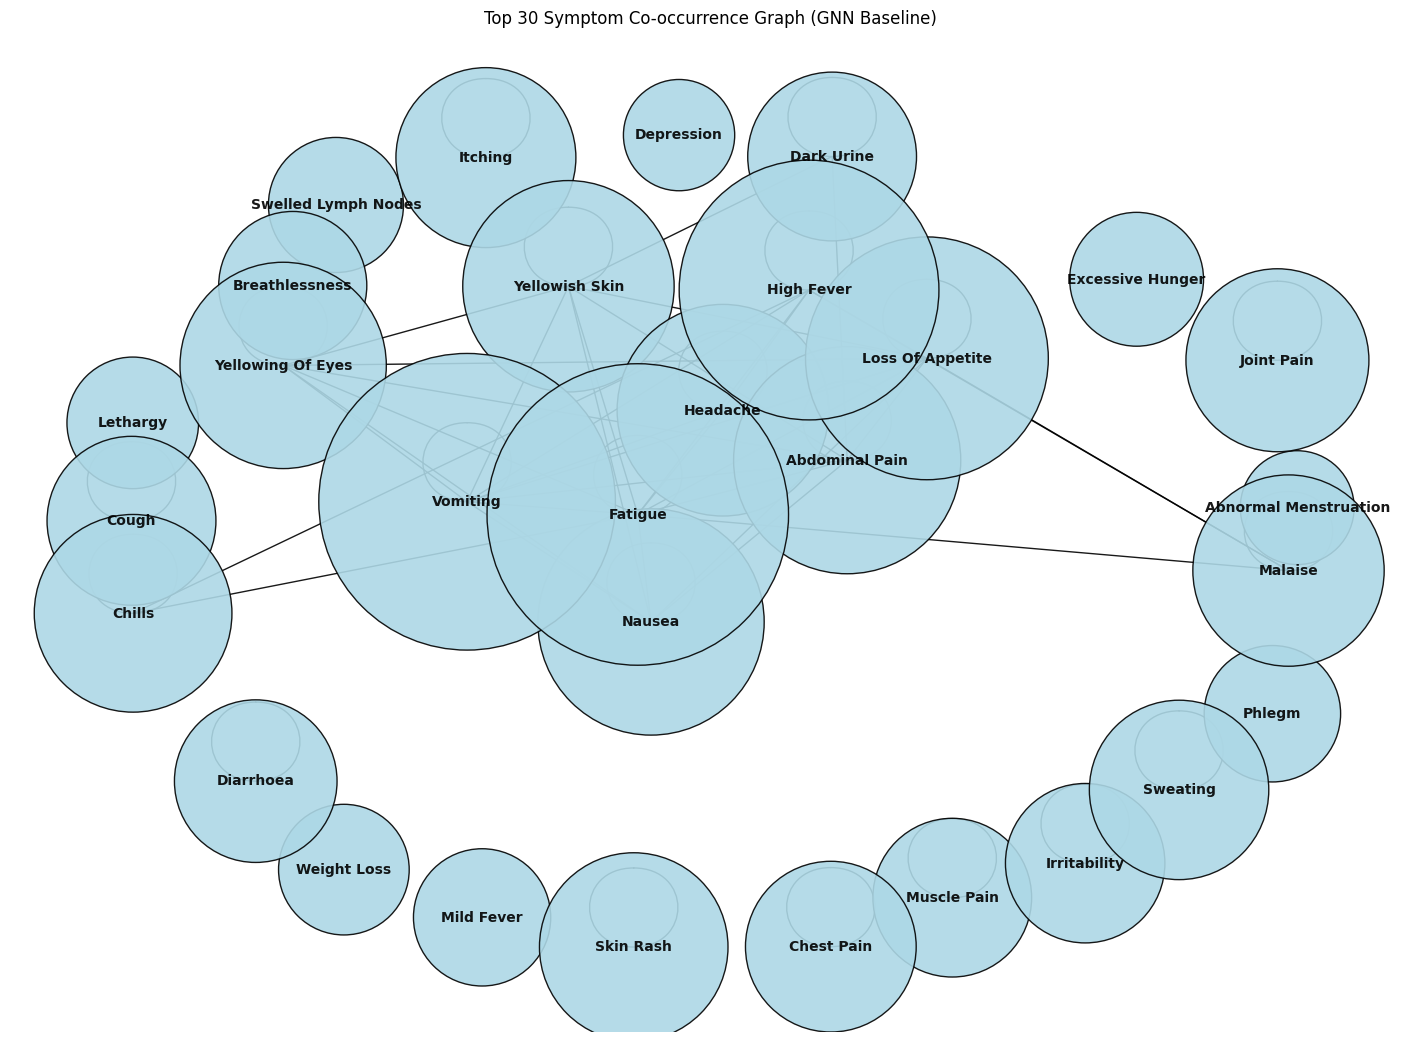

Graph saved as 'symptom_graph.png' — include in thesis.


In [23]:
print("Generating simple symptom co-occurrence graph...")

import networkx as nx

symptom_matrix = X_train_gnn[symptom_cols].values
cooc_matrix = symptom_matrix.T @ symptom_matrix

# Top 30 symptoms
freq = np.sum(symptom_matrix, axis=0)
top_idx = np.argsort(freq)[-30:]
top_symptoms = [symptom_cols[i].replace('_', ' ').title() for i in top_idx]
top_cooc = cooc_matrix[np.ix_(top_idx, top_idx)]

threshold = np.percentile(top_cooc[top_cooc > 0], 85)
adj = (top_cooc >= threshold).astype(int)

G = nx.from_numpy_array(adj)
G = nx.relabel_nodes(G, {i: top_symptoms[i] for i in range(len(top_symptoms))})

node_sizes = [freq[top_idx[i]] * 10 for i in range(len(top_symptoms))]

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=3, iterations=100, seed=42)

nx.draw(G, pos,
        node_color='lightblue',
        node_size=node_sizes,
        with_labels=True,
        font_size=10,
        font_weight='bold',
        alpha=0.9,
        edgecolors='black')

plt.title("Top 30 Symptom Co-occurrence Graph (GNN Baseline)")
plt.axis('off')
plt.savefig("symptom_graph.png", dpi=300, bbox_inches='tight')
plt.show()

print("Graph saved as 'symptom_graph.png' — include in thesis.")

## 8: Tokenize Data & Prepare Datasets

In [16]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

print("Tokenizing train and test data...")
train_ds = Dataset.from_dict({'text': train_texts, 'label': train_labels_enc})
test_ds = Dataset.from_dict({'text': test_texts, 'label': test_labels_enc})

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

train_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("Tokenization complete! Datasets ready for training.")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizing train and test data...


Map:   0%|          | 0/8586 [00:00<?, ? examples/s]

Map:   0%|          | 0/3681 [00:00<?, ? examples/s]

Tokenization complete! Datasets ready for training.


## 9: Fine-Tune BioBERT Model

In [17]:
print("Loading BioBERT model for fine-tuning...")
model = AutoModelForSequenceClassification.from_pretrained(
    "dmis-lab/biobert-v1.1", num_labels=n_classes
).to(device)

print("Model loaded (warning about new classifier head is normal)")

args = TrainingArguments(
    output_dir='./biobert_results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    fp16=True,
    report_to=[]
)

def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(labels, preds),
            'f1': f1_score(labels, preds, average='macro')}

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

print("\nStarting fine-tuning...")
trainer.train()
print("Fine-tuning completed!")

Loading BioBERT model for fine-tuning...


pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded (warning about new classifier head is normal)

Starting fine-tuning...


model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.796400,0.015809,1.000000,1.000000
2,0.014600,0.005232,1.000000,1.000000
3,0.006700,0.003263,1.000000,1.000000
4,0.004700,0.002793,1.000000,1.000000


Fine-tuning completed!


## 10: Final Evaluation, ROUGE Score, and Interactive Prediction with Severity

In [21]:
print("\nEvaluating on test set...")
results = trainer.evaluate()
bio_acc = results['eval_accuracy']
bio_f1 = results['eval_f1']

print(f"\nFINAL BIOBERT RESULTS")
print(f"Accuracy: {bio_acc:.4f}")
print(f"Macro F1: {bio_f1:.4f}")
print("="*80)

# NEW: ROUGE-L for medication recommendation (novelty)
print("\nCalculating ROUGE-L for medication recommendations...")
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

rouge_scores = []
for i in range(min(50, len(test_texts))):  # Sample 50 for speed
    inputs = tokenizer(test_texts[i], return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        probs = torch.softmax(model(**inputs).logits, dim=1).cpu().numpy()[0]
    pred_idx = np.argmax(probs)
    disease = le.inverse_transform([pred_idx])[0]
    predicted_meds = ', '.join(disease_to_meds.get(disease, []))
    ground_truth_meds = ', '.join(disease_to_meds.get(test_labels[i], []))
    if ground_truth_meds:
        score = scorer.score(ground_truth_meds, predicted_meds)['rougeL'].fmeasure
        rouge_scores.append(score)

if rouge_scores:
    avg_rouge = np.mean(rouge_scores)
    print(f"Average ROUGE-L score (medication overlap): {avg_rouge:.4f}")
else:
    print("No valid medication comparisons available.")


Evaluating on test set...



FINAL BIOBERT RESULTS
Accuracy: 1.0000
Macro F1: 1.0000

Calculating ROUGE-L for medication recommendations...
Average ROUGE-L score (medication overlap): 1.0000


## 11:Interactive prediction with severity input

In [25]:
def predict(symptoms_text, age, gender, allergies=[], current_meds=[], severity='Mild'):
    prompt = f"Symptoms: {symptoms_text}. Age: {age}. Gender: {gender}."
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        probs = torch.softmax(model(**inputs).logits, dim=1).cpu().numpy()[0]
    pred_idx = np.argmax(probs)
    confidence = float(probs[pred_idx])
    disease = le.inverse_transform([pred_idx])[0]

    all_meds = disease_to_meds.get(disease, [])

    priority_meds = severity_priority.get(disease, {}).get(severity, all_meds[:2])

    safe_meds = [m for m in priority_meds if not any(a.lower() in m.lower() for a in allergies + current_meds)]

    if confidence < 0.7:
        return f"Low confidence ({confidence:.1%}) — Possible: {disease}. Consult doctor."

    return f"{disease} ({confidence:.1%}) — Meds: {', '.join(safe_meds)}"

print("\nBIOBERT DIAGNOSIS SYSTEM READY")

print("Enter patient details below:")
while True:
    print("\n--- New Patient ---")
    symptoms = input("Symptoms (describe freely): ").strip()
    age = int(input("Age: "))
    gender = input("Gender (male/female/other): ").strip().lower()
    allergy_input = input("Allergies (comma-separated or 'none'): ").strip()
    allergies = [a.strip().lower() for a in allergy_input.split(',') if a.strip().lower() != 'none']
    current_input = input("Current medications (comma-separated or 'none'): ").strip()
    current_meds = [m.strip().lower() for m in current_input.split(',') if m.strip().lower() != 'none']
    severity = input("Severity (Mild/Moderate/Severe or press Enter for Mild): ").strip().title() or 'Mild'

    result = predict(symptoms, age, gender, allergies, current_meds, severity)

    print("\n" + "="*80)
    print(f"DIAGNOSIS     → {result}")
    print("="*80)

    again = input("\nDiagnose another patient? (yes/no): ").strip().lower()
    if again != 'yes':
        print("\nThank you! System closed.")
        break


BIOBERT DIAGNOSIS SYSTEM READY
Enter patient details below:

--- New Patient ---
Symptoms (describe freely): dischromatic patches, itching, skin rash
Age: 29
Gender (male/female/other): male
Allergies (comma-separated or 'none'): none
Current medications (comma-separated or 'none'): none
Severity (Mild/Moderate/Severe or press Enter for Mild): Mild

DIAGNOSIS     → Fungal infection (89.4%) — Meds: Antifungal Cream, Clotrimazole

Diagnose another patient? (yes/no): yes

--- New Patient ---
Symptoms (describe freely): dischromatic patches, itching, skin rash
Age: 29
Gender (male/female/other): male
Allergies (comma-separated or 'none'): none
Current medications (comma-separated or 'none'): none
Severity (Mild/Moderate/Severe or press Enter for Mild): Moderate

DIAGNOSIS     → Fungal infection (89.4%) — Meds: Fluconazole, Ketoconazole

Diagnose another patient? (yes/no): yes

--- New Patient ---
Symptoms (describe freely): dischromatic patches, itching, skin rash
Age: 29
Gender (male/fem

## 12: Performance Comparison Bar Chart

Generating performance comparison bar chart...


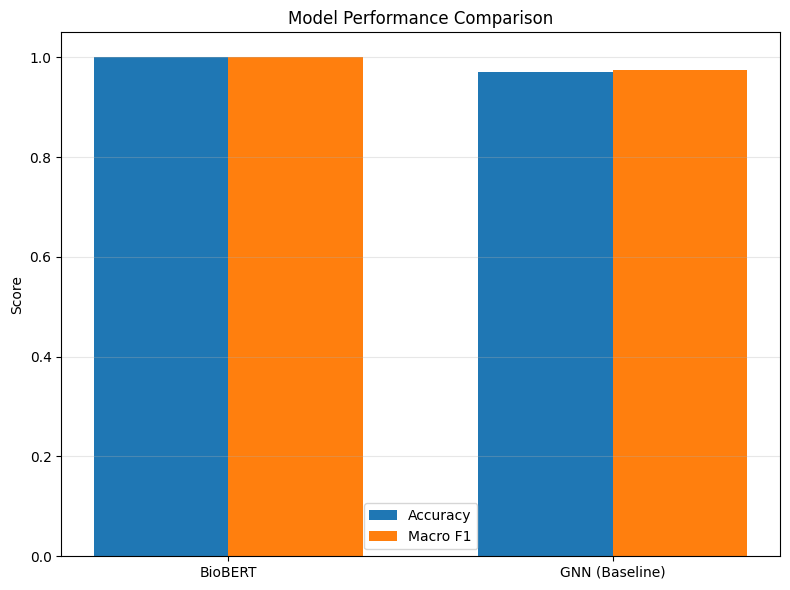

Comparison chart saved as 'model_comparison.png'


In [26]:
print("Generating performance comparison bar chart...")

models = ['BioBERT', 'GNN (Baseline)']
acc = [bio_acc, gnn_acc]
f1 = [bio_f1, gnn_f1]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width/2, acc, width, label='Accuracy')
ax.bar(x + width/2, f1, width, label='Macro F1')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300)
plt.show()

print("Comparison chart saved as 'model_comparison.png'")